# Symbolic regression using cartesian genetic programming

Here we're going to use pycartgp library to find an exact expression of some unknown function, knowing only its data points.

In [1]:
import math
import pycartgp
import matplotlib.pyplot as plt

## The dataset
First we need a dataset: a bunch of X and Ys for an "unknown" function.

In [2]:
def unknown_function(x):
    return x**3 + 2 * x**2 + 3*x + 5

num_points = 50
all_x = [0.1 * (i - num_points/2) for i in range(num_points)]
all_y = [unknown_function(x) for x in all_x]

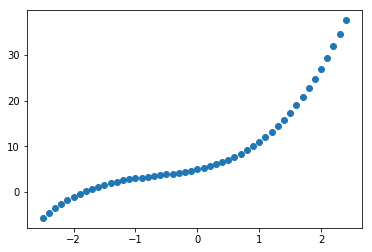

In [3]:
plt.scatter(all_x, all_y)

## Functions and fitness

To evaluate the solutions we need a fitness function. Here we use negative [MSE](https://en.wikipedia.org/wiki/Mean_squared_error).

In [4]:
def fitness(genotype: pycartgp.Genotype, functions) -> float:
    error = 0
    for x, y in zip(all_x, all_y):
        ty = genotype.evaluate(functions, [x])[0]
        error += (y - ty)**2
    return -error / len(all_x)

We also need a list of functions we're going to build the solution from.

In [5]:
available_functions = [
    ("plus", lambda args: args[0] + args[1]),
    ("minus", lambda args: args[0] - args[1]),
    ("mul", lambda args: args[0] * args[1]),
    ("div", lambda args: (args[0] / args[1]) if args[1] != 0 else 1),  # "protected" division
]

# Evolving a solution

We create a random genotype, the ancestor of our final solution. Because it's random, it's totally meaningless.

In [6]:
genotype = pycartgp.Genotype(
    arity=2,
    num_functions=len(available_functions),
    num_inputs=1,
    num_outputs=1, depth=100)
print(genotype.raw)
print(genotype.explain_outputs(available_functions))

[0, 0, 0, 1, 1, 1, 3, 2, 2, 2, 0, 0, 1, 3, 3, 0, 2, 3, 1, 1, 1, 0, 0, 5, 2, 4, 8, 3, 2, 2, 2, 10, 0, 2, 7, 3, 0, 11, 4, 0, 5, 8, 1, 3, 9, 1, 15, 7, 1, 5, 14, 3, 15, 14, 3, 13, 9, 1, 3, 3, 1, 0, 16, 1, 11, 2, 2, 7, 19, 3, 20, 22, 3, 9, 22, 2, 8, 0, 0, 15, 14, 0, 7, 0, 0, 0, 25, 1, 3, 28, 0, 0, 12, 2, 6, 27, 0, 32, 5, 1, 9, 11, 0, 4, 15, 0, 22, 34, 1, 31, 7, 2, 26, 18, 0, 11, 7, 0, 11, 18, 0, 15, 21, 2, 27, 27, 3, 19, 38, 2, 11, 31, 1, 25, 18, 3, 20, 20, 0, 43, 14, 3, 36, 27, 2, 14, 11, 3, 10, 24, 2, 0, 0, 2, 2, 23, 1, 27, 34, 3, 22, 4, 2, 26, 33, 3, 45, 33, 2, 26, 30, 2, 5, 18, 0, 25, 8, 0, 51, 4, 3, 51, 13, 1, 36, 29, 2, 19, 2, 2, 10, 14, 3, 25, 35, 1, 29, 44, 3, 41, 41, 3, 43, 23, 3, 66, 24, 3, 52, 37, 1, 41, 25, 2, 67, 70, 2, 0, 30, 1, 71, 71, 0, 59, 44, 3, 24, 50, 3, 75, 68, 2, 76, 3, 1, 57, 31, 2, 4, 42, 2, 1, 25, 0, 9, 15, 2, 69, 9, 2, 50, 3, 2, 78, 44, 2, 3, 66, 2, 29, 78, 3, 43, 44, 3, 80, 84, 1, 23, 45, 2, 87, 15, 3, 44, 68, 2, 41, 9, 3, 31, 26, 1, 73, 32, 3, 39, 19, 2, 44, 10,

Now we can run the evolution until the solution stabilizes (fitness stops improving).

In [7]:
solution, info = genotype.evolve(
    available_functions, num_offsprings=4, stable_margin=1e-6,
    steps_to_stabilize=1000, fitness_function=fitness)
print('Steps taken:', info.steps)
print('Final fitness:', info.fitness)

Steps taken: 1753
Final fitness: -2.1457016622011523e-30


The evolved expression can be lengthy, because evolution had to "invent" how to construct everything (like constants, etc.) from the only input.

In [8]:
solution.explain_outputs(available_functions)[0]

'plus(plus(plus(plus(div(In0, plus(In0, minus(In0, In0))), mul(plus(In0, minus(In0, In0)), plus(In0, minus(In0, In0)))), plus(minus(div(In0, plus(In0, minus(In0, In0))), minus(plus(In0, minus(In0, In0)), minus(In0, In0))), plus(In0, minus(In0, In0)))), mul(plus(div(In0, plus(In0, minus(In0, In0))), minus(plus(In0, minus(In0, In0)), minus(In0, In0))), plus(plus(div(In0, plus(In0, minus(In0, In0))), mul(plus(In0, minus(In0, In0)), plus(In0, minus(In0, In0)))), plus(minus(div(In0, plus(In0, minus(In0, In0))), minus(plus(In0, minus(In0, In0)), minus(In0, In0))), plus(In0, minus(In0, In0)))))), plus(div(plus(In0, minus(In0, In0)), div(minus(In0, In0), minus(In0, In0))), plus(minus(div(In0, plus(In0, minus(In0, In0))), minus(plus(In0, minus(In0, In0)), minus(In0, In0))), plus(In0, minus(In0, In0)))))'

We can plot the evolved solution and see how well it fits the dataset

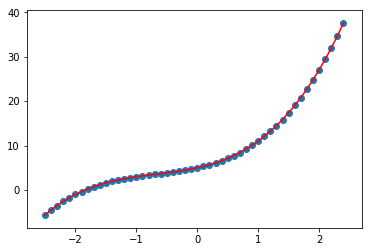

In [9]:
plt.plot(all_x, [solution.evaluate(available_functions, [x])[0] for x in all_x], 'r')
plt.scatter(all_x, all_y)

## Human-readable form
We can evaluate the evolved solution using SymPy symbols instead of numbers and thus get a valid SymPy
expression that is much more readable and can even be further simplified

In [10]:
import sympy
sympy.init_printing()
sympy_expr = solution.evaluate(available_functions, [sympy.symbols('x')])[0]
sympy.simplify(sympy.expand(sympy_expr))